# Team Challenge Image Analysis - Team 6

This notebook shows an example workflow for the proposed image analysis software, it consists of two parts: training and evaluation. More information about the setup and file structure can be found on the Github page.

## Part 0: Setup
In this part, the general setup for the workflow will be done. This consists of changing the working directory to be `root` and performing relevant imports. 

In [1]:
# Change working directory to the root folder
import os, sys
if os.path.split(os.getcwd())[-1] != 'TeamChallenge_team6':
    %cd ..
    
    if os.path.split(os.getcwd())[-1] != 'TeamChallenge_team6':
        raise UserError("Something went wrong in the directory reassignment!")

# Add relevant directories to path
if "" not in sys.path : sys.path.append("")
if "src" not in sys.path : sys.path.append("src")

D:\Users\sjors\Documents\TUe\MSc\TeamChallenge\TeamChallenge_team6


In [2]:
# Relevant imports
import os
from data_preperation import data_prep, inspect_data
from preprocessing import preprocess_data
from model import define_discriminator, define_generator, define_gan
from training import train
from evaluation import evaluate, get_fsl_metrics, resp_vec_correlation
from util.tf_session import setup_tf_session
from util.general import *

# Setup the tf session for possible gpu usage
n_gpus = setup_tf_session()

Using TensorFlow backend.


## Part 1: Training
In this part, the cGAN model will be trained. It will do so by first preprocessing the data, after which the datasets will be loaded and the models are defined. Hereafter, the actual training process is performed. By default, we'll be training for 100 epochs with a batch size of 4 and an augmentation factor of 20. 

### 1a: Data preprocessing

In [3]:
preprocess_data("data", verbose=True)

Performing data preprocessing in directory:
D:\Users\sjors\Documents\TUe\MSc\TeamChallenge\TeamChallenge_team6\data


100%|#################################################################################| 22/22 [00:00<00:00, 118.28it/s]


### 1b: Dataset generation

##### Data loading

In [4]:
# Load data
print("Dataset - TRAIN")
dataset_train, train_subjects = data_prep(os.path.join("data", "preprocessed"), True, "train", verbose=True)
print("Dataset - TEST")
dataset_test, test_subjects = data_prep(os.path.join("data", "preprocessed"), True, "test", verbose=True)

# Define image shape
image_shape = dataset_train[0].shape[1:]
image_shape = (image_shape[0], image_shape[1], 1)

Dataset - TRAIN
Extracting data for subject 'rat29' (1/16)...	Completed
Extracting data for subject 'rat71' (2/16)...	Completed
Extracting data for subject 'rat32' (3/16)...	Completed
Extracting data for subject 'rat34' (4/16)...	Completed
Extracting data for subject 'rat72' (5/16)...	Completed
Extracting data for subject 'rat96' (6/16)...	Completed
Extracting data for subject 'rat25' (7/16)...	Completed
Extracting data for subject 'rat31' (8/16)...	Completed
Extracting data for subject 'rat63' (9/16)...	Completed
Extracting data for subject 'rat35' (10/16)...	Completed
Extracting data for subject 'rat61' (11/16)...	Completed
Extracting data for subject 'rat84' (12/16)...	Completed
Extracting data for subject 'rat70' (13/16)...	Completed
Extracting data for subject 'rat26' (14/16)...	Completed
Extracting data for subject 'rat62' (15/16)...	Completed
Extracting data for subject 'rat89' (16/16)...	Completed

Completed data extraction!
Found a total of 48 slices

Dataset - TEST
Extracting

##### Data inspection
We will now also have a look at some of the preprocessed images for quality assurance and a better understanding in the inner workings of the pipeline. Please note that here, the left image is the day 3 image (input), while the right image is the day 0 image (target). You'll notice that the image used are brain extracted and cropped in such a way as to center the brain as much as possible. Also, a histogram equalization is performed to yield better image contrast.

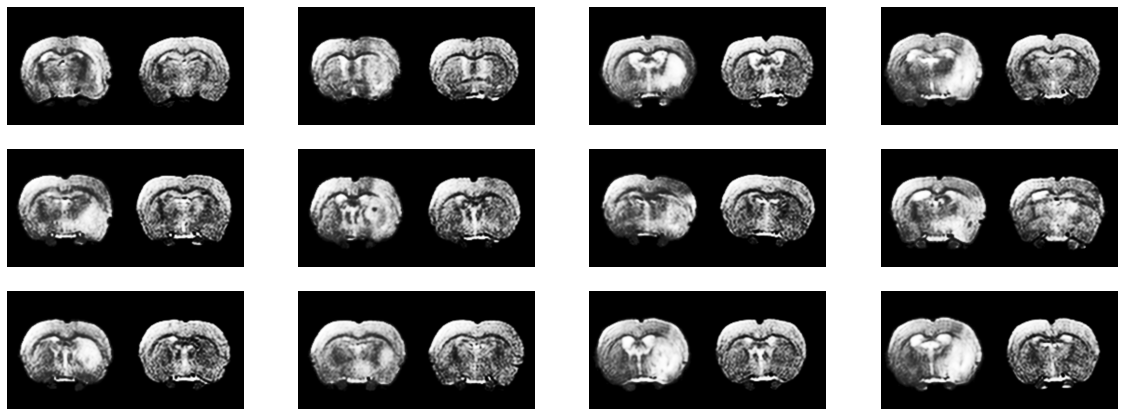

In [5]:
inspect_data(dataset_train, n_samples = 12)

### 1c: Model definition

In [6]:
# TODO: We should add Roos's schematic here!

# Define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)

gan_model = define_gan(g_model, d_model, image_shape)

# Show model summaries
print(print_style.BOLD+"=== DISCRIMINATOR MODEL ==="+print_style.END)
d_model.summary()
print(print_style.BOLD+"\n\n===== GENERATOR MODEL ====="+print_style.END)
g_model.summary()
print(print_style.BOLD+"\n\n======== GAN MODEL ========"+print_style.END)
gan_model.summary()

=== DISCRIMINATOR MODEL ===
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 256, 256, 2)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 2112       

D:\ProgramData\Anaconda3\envs\TeamChallenge\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


### 1d: Actual training

In [ ]:
# Train model
run_name = train(d_model, g_model, gan_model, dataset_train, n_epochs=100, n_batch=4)

## Part 2: Evaluation

Based on the training we did above, we can evaluate the best performing model. First choose which model (based on step) you want to evaluate (e.g. "0029400"), you can do this by typing the following into your prompt (with specified path to logs): 

tensorboard --logdir "../logs" 

and go to http://localhost:6006/

The step which resulted in the best performing step can be specified in the specific_model parameter below to evaluate the correpsonding model ("last" argument results in evaluating the model from the last step).

D:\ProgramData\Anaconda3\envs\TeamChallenge\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


SSIM (day0 v day0_pred) for slice 0:  0.7355185435175634
SSIM (day4 v day0_pred) for slice 0:  0.7593169645305486
SSIM (day0 v day0_pred) for slice 1:  0.7496994880250188
SSIM (day4 v day0_pred) for slice 1:  0.7676558672633422
SSIM (day0 v day0_pred) for slice 2:  0.7607431409733675
SSIM (day4 v day0_pred) for slice 2:  0.7681378354490228
SSIM (day0 v day0_pred) for slice 3:  0.7475467663268769
SSIM (day4 v day0_pred) for slice 3:  0.8057322408799625
SSIM (day0 v day0_pred) for slice 4:  0.741228650084939
SSIM (day4 v day0_pred) for slice 4:  0.8088580921634808
SSIM (day0 v day0_pred) for slice 5:  0.7494895448398596
SSIM (day4 v day0_pred) for slice 5:  0.8070905255970958
SSIM (day0 v day0_pred) for slice 6:  0.719019436845225
SSIM (day4 v day0_pred) for slice 6:  0.7905417615295257
SSIM (day0 v day0_pred) for slice 7:  0.7112003031617603
SSIM (day4 v day0_pred) for slice 7:  0.7609979808186241
SSIM (day0 v day0_pred) for slice 8:  0.7111805715214171
SSIM (day4 v day0_pred) for slice

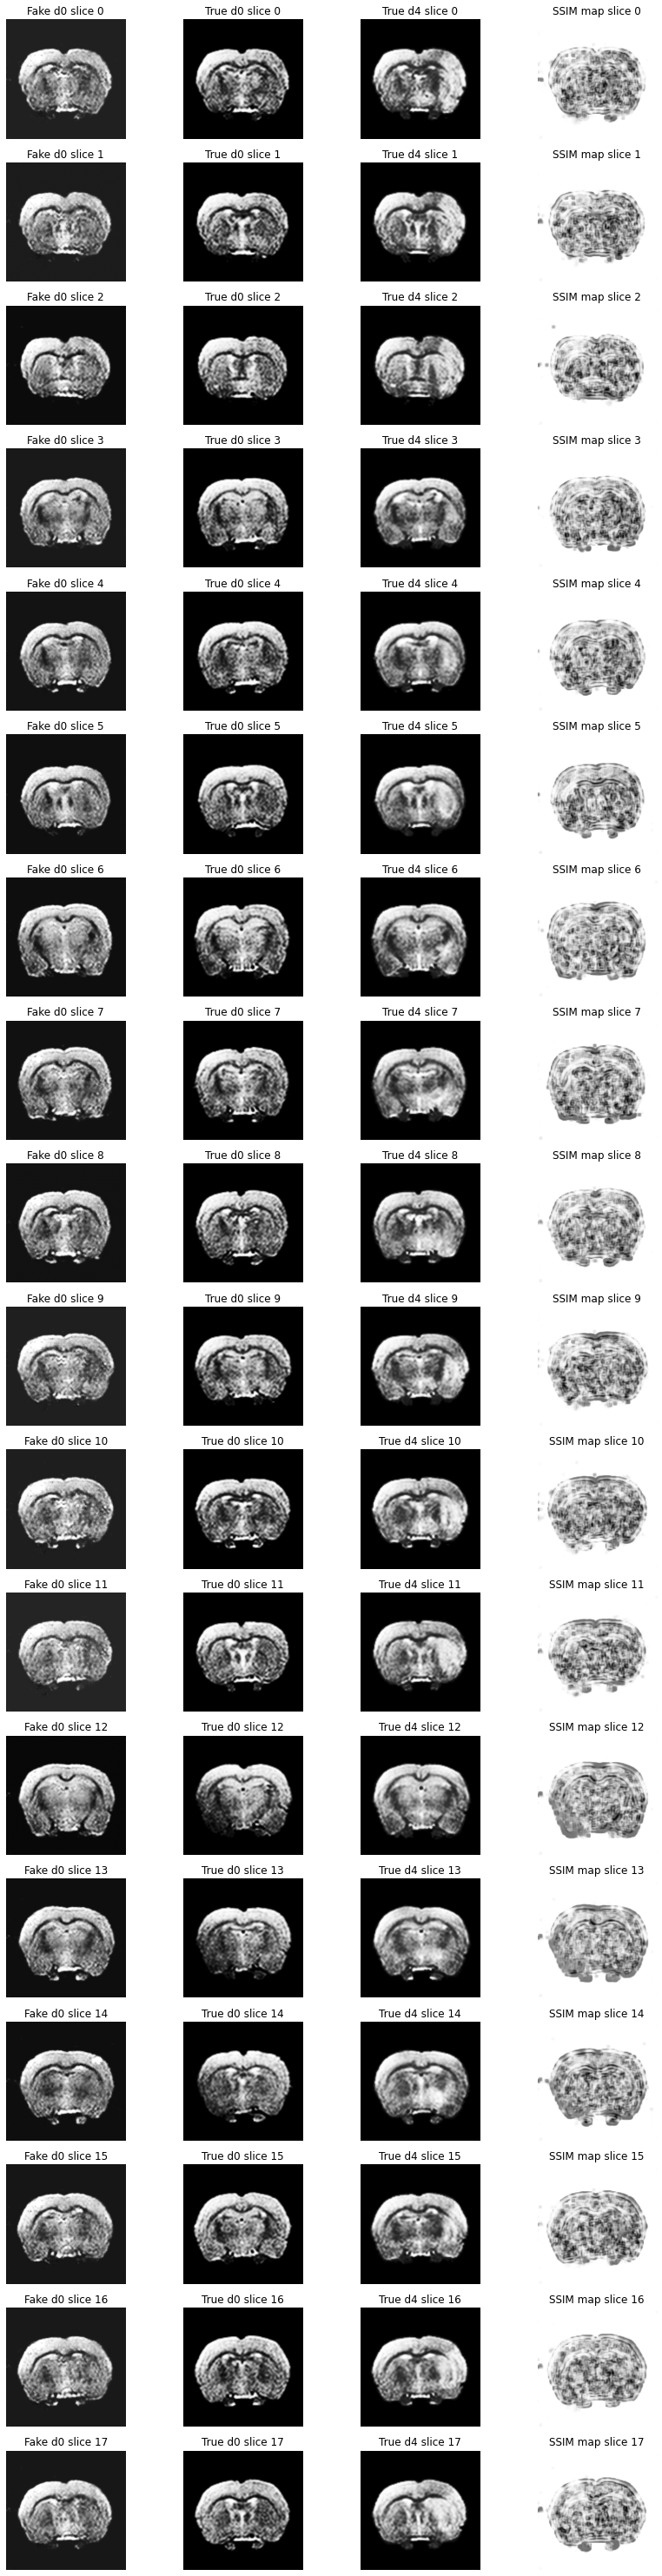

In [7]:
# Calculate SSIM for our cGAN method
eval_SSIMs = evaluate(d_model, g_model, gan_model, dataset_test, time=run_name, specific_model="last")

In [ ]:
# Calculate SSIM and DSC for the FSL method (Bart's method)
fsl_SSIM, fsl_DSC = get_fsl_metrics("data", test_subjects)

# Perform correlation analysis with the response vector data
resp_vec_cor = resp_vec_correlation("data", test_subjects, eval_SSIMs)